# Project 1: Mining information from Text Data 
<hr>

This project will explore and analyze the information stored in a particular dataset. In this case the ACL Anthology dataset (https://aclanthology.org/). We will explore different techniques for obtainingn valuable information.

## Task 1: Finding Similar Items

Randomly select 1000 abstracts from the whole dataset. Find the similar items using pairwise Jaccard similarities, MinHash and LSH (vectorized versions) .

1. Compare the performance in time and the results for k-shingles = 3, 5 and 10, for the three methods and similarity thresholds s=0.1 and 0.2. Use 50 hashing functions. Comment your results.

2. Compare the results obtained for MinHash and LSH for different similarity thresholds s = 0.1, 0.2 and 0.25 and 50, 100 and 200 hashing functions. Comment your results.

3. For MinHashing using 100 hashing functions and s = 0.1 and 0.2, find the Jaccard distances (1-Jaccard similarity) for all possible pairs. Use the obtained values within a k-NN algorithm, and for k=1,3 and, 5 identify the clusters with similar abstracts for each s. Describe the obtained clusters, are they different?. Select randomly at least 5 abstracts per cluster, upon visual inspection, what are the main topics?

 
 

<hr>

#### 1. Compare the performance in time and the results for k-shingles = 3, 5 and 10, for the three methods and similarity thresholds s=0.1 and 0.2. Use 50 hashing functions. Comment your results.

0. Import libraries

In [24]:
from urllib.request import urlopen
from io import BytesIO
from time import time

import gzip
import re
import binascii
import random
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os


1. Load data and make some preprocessing

In [25]:
url  = 'https://aclanthology.org/anthology+abstracts.bib.gz'
filename = 'anthology+abstracts.bib'
minimum = 200

if(not os.path.exists(filename)):
  print("downloading %s"%url)
  with gzip.open(BytesIO(urlopen(url).read()), 'rb') as fb:
    with open(filename, 'wb') as f:
        f.write(fb.read())

file = open(filename)
abstracts = []
titles = []
with open(filename, 'r',errors='ignore') as f:
    # skip all lines until abstract
    for line in f:
      if ' title = "' in line:
        line = re.sub(' title = "', '', line)         
        title = line
      if 'abstract = "' in line:                                  # abstract found
        if len(re.findall('[a-zA-Z]', line)) > .2*len(line):      # ignore non latin
          if len(line) > minimum:                                 # ignore abstracts with less than minimum words (200)
            line = re.sub(' +', ' ', line)                        # remove double spaces
            line = re.sub(' abstract = ', '', line)               # remove "abstract ="
            line = re.sub('"|\n|,', '', line)                     # remove some other characters  
            line = line.lower()                                   # transform to lower letters             
            abstracts.append(line)
            titles.append(title)

print('Number of abstracts:', len(abstracts))
print('Example:', abstracts[0])
print('\nTitle:', titles[0])       

Number of abstracts: 30071
Example: offensive language detection (old) has received increasing attention due to its societal impact. recent work shows that bidirectional transformer based methods obtain impressive performance on old. however such methods usually rely on large-scale well-labeled old datasets for model training. to address the issue of data/label scarcity in old in this paper we propose a simple yet effective domain adaptation approach to train bidirectional transformers. our approach introduces domain adaptation (da) training procedures to albert such that it can effectively exploit auxiliary data from source domains to improve the old performance in a target domain. experimental results on benchmark datasets show that our approach albert (da) obtains the state-of-the-art performance in most cases. particularly our approach significantly benefits underrepresented and under-performing classes with a significant improvement over albert.

Title:    Exploiting Auxiliary Dat

2. Randomly select 1000 abstracts

In [26]:
# initializing the value of n_abstracts
n_abstracts= 1000
  
# getting random n elements from the list
abstracts = random.sample(abstracts, n_abstracts)
print('Number of abstracts:', len(abstracts))

Number of abstracts: 1000


3. Define main functions

In [27]:
def get_shingles(a, k):
    L = len(a)
    shingles = set()                                  # we use a set to automatically eliminate duplicates
    for i in range(L-k+1):
        shingle = a[i:i+k]
        crc = binascii.crc32(shingle.encode('utf-8')) # hash the shingle to a 32-bit integer
        shingles.add(crc)    
    return shingles     

In [28]:
def jaccard_similarity_score(x, y):
    intersection_cardinality = len(set(x).intersection(set(y)))
    union_cardinality = len(set(x).union(set(y)))
    return intersection_cardinality / float(union_cardinality)

In [29]:
def minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig):
    signature = np.ones((nsig,)) * (maxShingleID + 1)

    for ShingleID in shingles:
        hashCodes = ((A*ShingleID + B) % nextPrime) % maxShingleID
        np.minimum(signature, hashCodes, out=signature)

    return signature

In [30]:
def LSH(signatures, bands, rows, Ab, Bb, nextPrime, maxShingleID):
    numItems = signatures.shape[1]
    signBands = np.array_split(signatures, bands, axis=0)
    candidates = set()
    for nb in range(bands):
        hashTable = {}
        for ni in range(numItems):
            item = signBands[nb][:,ni]
            hash = (np.dot(Ab[nb,:], item) + Bb[nb]) % nextPrime % maxShingleID
            if hash not in hashTable:
                hashTable[hash] = [ni]
            else:
                hashTable[hash].append(ni)
        for _,items in hashTable.items():
            if len(items) > 1:
                L = len(items)
                for i in range(L-1):
                    for j in range(i+1, L):
                        cand = [items[i], items[j]]
                        np.sort(cand)
                        candidates.add(tuple(cand))
    return candidates

In [31]:
def plot_results(title, times, num_of_similar_items):
    plt.rcParams["figure.figsize"] = (15,6)

    plt.subplot(1,2,1)
    objects = ('S=0.1/K=3', 'S=0.1/K=5', 'S=0.1/K=10', 'S=0.2/K=3', 'S=0.2/K=5', 'S=0.2/K=10')
    y_pos = np.arange(len(objects))
    metric = times
    plt.barh(y_pos, metric, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.title(title +' (time)')

    plt.subplot(1,2,2)
    y_pos = np.arange(len(objects))
    metric = num_of_similar_items
    plt.barh(y_pos, metric, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.title(title + ' (items)')

    plt.show()

4. Jaccard Similarity: (CAUTION: This process takes long execution time!!)

In [75]:
similarity_threshold = [0.1, 0.2]
k_shingles = [3, 5, 10]

num_of_similar_items = []
times = []

for s in similarity_threshold:
    for k in k_shingles:

        candidates = []
        t = time()
        for pair in itertools.combinations(abstracts,2):
            js = jaccard_similarity_score(get_shingles(pair[0], k),get_shingles(pair[1], k))    
            if js > s:
                candidates.append(pair)
        t1 = time()-t
        print('Similarity threshold:', s)        
        print('K_Shingles:', k)        
        print('Num of candidates found:', len(candidates))    
        print("Took {} seconds\n".format(t1))     
        num_of_similar_items.append(len(candidates))
        times.append(t1)
        

Similarity threshold: 0.1
K_Shingles: 3
Num of candidates found: 497908
Took 395.5292649269104 seconds

Similarity threshold: 0.1
K_Shingles: 5
Num of candidates found: 5980
Took 417.7846202850342 seconds

Similarity threshold: 0.1
K_Shingles: 10
Num of candidates found: 0
Took 436.5822627544403 seconds

Similarity threshold: 0.2
K_Shingles: 3
Num of candidates found: 359787
Took 406.6555950641632 seconds

Similarity threshold: 0.2
K_Shingles: 5
Num of candidates found: 0
Took 409.440797328949 seconds

Similarity threshold: 0.2
K_Shingles: 10
Num of candidates found: 0
Took 416.746798992157 seconds



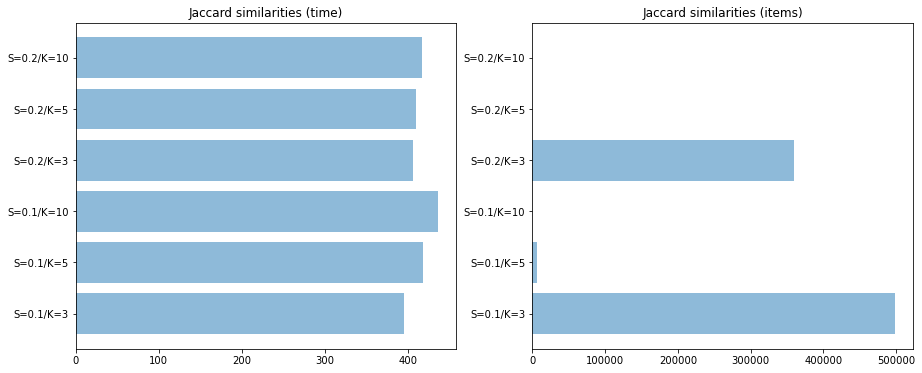

In [76]:
plot_results('Jaccard similarities', times, num_of_similar_items)

5. MinHashing

In [32]:
# get candidate pairs using MinHashing
# set global parameters to process the whole dataset
bands = 10         # number of bands
rows = 5           # number of rows
nsig = bands*rows  # number of elements in signature, or the number of different random hash functions

maxShingleID = 2**32-1  # record the maximum shingle ID that we assigned
nextPrime = 4294967311  # next prime number after maxShingleID

A = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)
B = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)

similarity_threshold = [0.1, 0.2]
k_shingles = [3, 5, 10]

num_of_similar_items = []
times = []

for s in similarity_threshold:
    
    for k in k_shingles:
        
        signatures = []  # signatures for all files
        
        for a in abstracts:
            shingles = get_shingles(a, k)
            signature = minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig)
            signatures.append(signature)
            
        Nfiles = len(signatures)
        
        t = time()
        candidates = []
        for i in range(Nfiles):
            for j in range(i+1, Nfiles):
                Jsim = np.mean(signatures[i] == signatures[j])     # average number of similar items in 
                if Jsim >= s:                                      # two vectors, equivalent to Jaccard 
                    candidates.append((i,j))
        t1 = time() - t

        print('Similarity threshold:', s)        
        print('K_Shingles:', k)        
        print('Num of candidates found:', len(candidates))    
        print("Took {} seconds\n".format(t1))     
        
        num_of_similar_items.append(len(candidates))
        times.append(t1)        

        

Similarity threshold: 0.1
K_Shingles: 3
Num of candidates found: 466306
Took 4.299259185791016 seconds

Similarity threshold: 0.1
K_Shingles: 5
Num of candidates found: 90895
Took 4.207795858383179 seconds

Similarity threshold: 0.1
K_Shingles: 10
Num of candidates found: 629
Took 4.149080514907837 seconds

Similarity threshold: 0.2
K_Shingles: 3
Num of candidates found: 236574
Took 4.219400405883789 seconds

Similarity threshold: 0.2
K_Shingles: 5
Num of candidates found: 1075
Took 4.206144332885742 seconds

Similarity threshold: 0.2
K_Shingles: 10
Num of candidates found: 2
Took 4.136088132858276 seconds



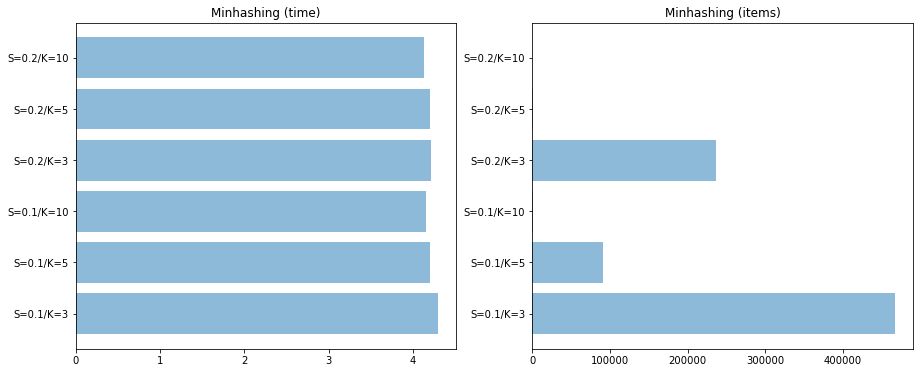

In [33]:
plot_results('Minhashing', times, num_of_similar_items)

6. Locality Sensitive Hashing (LSH)

In [46]:
# Find candidates with LSH --> S=0.1 and S=0.2
list = [(100,2),(125,3)]

num_of_similar_items = []
times = []

for (bands,rows) in list:
    nsig = bands*rows  # number of elements in signature, or the number of different random hash functions

    maxShingleID = 2**32-1  # record the maximum shingle ID that we assigned
    nextPrime = 4294967311  # next prime number after maxShingleID

    A = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)
    B = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)

    k_shingles = [3, 5, 10]

    for k in k_shingles:
        signatures = []  # signatures for all files
        for a in abstracts:
            shingles = get_shingles(a, k)
            signature = minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig)
            signatures.append(signature)

        # prepare data for LSH
        A2 = np.random.randint(0, nextPrime/2, size=(bands, rows),dtype=np.int64)  # now we need a vector of A parameters for each band
        B2 = np.random.randint(0, nextPrime/2, size=(bands, ),dtype=np.int64)
        signatures = np.array(signatures).T  # LSH needs a matrix of signatures, not a list of vectors

        #s = 0.95  # NO similarity threshold, why? The threshold is implicit when we choose the number of rows (r) and the number of bands (b)
        Nfiles = signatures.shape[1]  # number of different files
        t = time()
        candidates = LSH(signatures, bands, rows, A2, B2, nextPrime, maxShingleID)
        t1 = time() - t
     
        print('K_Shingles:', k)        
        print('Num of candidates found:', len(candidates))    
        print("Took {} seconds\n".format(t1))     
        num_of_similar_items.append(len(candidates))
        times.append(t1)  

K_Shingles: 3
Num of candidates found: 483431
Took 8.996078491210938 seconds

K_Shingles: 5
Num of candidates found: 126652
Took 1.086963415145874 seconds

K_Shingles: 10
Num of candidates found: 2323
Took 0.3969907760620117 seconds

K_Shingles: 3
Num of candidates found: 352239
Took 3.343503475189209 seconds

K_Shingles: 5
Num of candidates found: 13870
Took 0.5920147895812988 seconds

K_Shingles: 10
Num of candidates found: 48
Took 0.4649934768676758 seconds



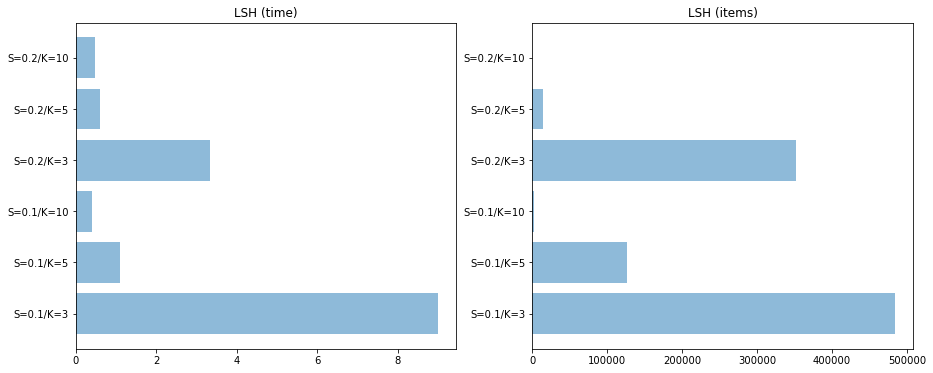

In [47]:
plot_results('LSH', times, num_of_similar_items)

200 0.1
375 0.2
180 0.2554364774645177


Text(0.5, 1.0, 'Similarity threshold = 0.25')

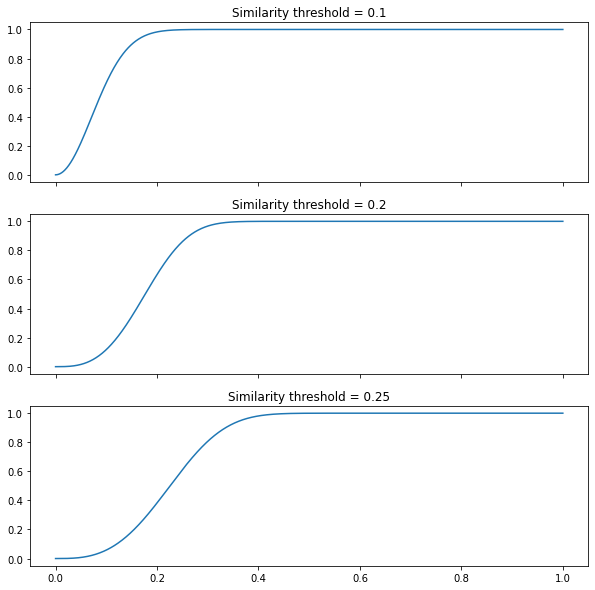

In [48]:
# Plot the selected number of bands and rows to obtain the desired threshold

# s = 0.1
b1 = 100
r1 = 2
print(b1*r1, (1.0/b1)**(1.0/r1))

# s = 0.2
b2 = 125
r2 = 3
print(b2*r2, (1.0/b2)**(1.0/r2))

# s = 0.25
b3 = 60
r3 = 3
print(b3*r3, (1.0/b3)**(1.0/r3))

t = np.linspace(0,1,1000)  # just lots of points between 0 and 1 for plotting
p1 = 1 - np.power((1 - np.power(t, r1)), b1)  # Formula: p = 1 - (1 - t^r)^b 
p2 = 1 - np.power((1 - np.power(t, r2)), b2)  # Formula: p = 1 - (1 - t^r)^b 
p3 = 1 - np.power((1 - np.power(t, r3)), b3)  # Formula: p = 1 - (1 - t^r)^b 

plt.rcParams["figure.figsize"] = (10,10)

fig, axs = plt.subplots(3, sharex=True, sharey=True)
axs[0].plot(t,p1)
axs[0].set_title('Similarity threshold = 0.1')
axs[1].plot(t,p2)
axs[1].set_title('Similarity threshold = 0.2')
axs[2].plot(t,p3)
axs[2].set_title('Similarity threshold = 0.25')

7. Comments

With these exexcutions we have seen that MinHash and LSH techniques provide an estimate of Jaccard Similarity Coefficient with much fewer computations.

LSH performs much faster than the other techniques but also includes more false positives and false negatives.

<hr>

#### 2. Compare the results obtained for MinHash and LSH for different similarity thresholds s = 0.1, 0.2 and 0.25 and 50, 100 and 200 hashing functions. Comment your results.

Minhashing

In [42]:
# get candidate pairs using MinHashing
# set global parameters to process the whole dataset
list = [(10,5),(10,10),(20,10)]
for (bands,rows) in list:
    nsig = bands*rows  # number of elements in signature, or the number of different random hash functions

    maxShingleID = 2**32-1  # record the maximum shingle ID that we assigned
    nextPrime = 4294967311  # next prime number after maxShingleID

    A = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)
    B = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)

    similarity_threshold = [0.1, 0.2, 0.25]
    k_shingles = [3,5,10]

    num_of_similar_items = []
    times = []

    for s in similarity_threshold:            
        for k in k_shingles:
            signatures = []  # signatures for all files
        
            for a in abstracts:
                shingles = get_shingles(a, k)
                signature = minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig)
                signatures.append(signature)
            
            Nfiles = len(signatures)
        
            t = time()
            candidates = []
            for i in range(Nfiles):
                for j in range(i+1, Nfiles):
                    Jsim = np.mean(signatures[i] == signatures[j])     # average number of similar items in 
                    if Jsim >= s:                                      # two vectors, equivalent to Jaccard 
                        candidates.append((i,j))
            t1 = time() - t

            print('Similarity threshold:', s)        
            print('K_Shingles:', k)
            print('Num of hashing functions:', nsig)        
            print('Num of candidates found:', len(candidates))    
            print("Took {} seconds\n".format(t1))     

            num_of_similar_items.append(len(candidates))
            times.append(t1)        

Similarity threshold: 0.1
K_Shingles: 3
Num of hashing functions: 50
Num of candidates found: 486862
Took 4.335970640182495 seconds

Similarity threshold: 0.1
K_Shingles: 5
Num of hashing functions: 50
Num of candidates found: 197880
Took 4.224617004394531 seconds

Similarity threshold: 0.1
K_Shingles: 10
Num of hashing functions: 50
Num of candidates found: 111
Took 4.205479383468628 seconds

Similarity threshold: 0.2
K_Shingles: 3
Num of hashing functions: 50
Num of candidates found: 325703
Took 4.211967706680298 seconds

Similarity threshold: 0.2
K_Shingles: 5
Num of hashing functions: 50
Num of candidates found: 5903
Took 4.17325496673584 seconds

Similarity threshold: 0.2
K_Shingles: 10
Num of hashing functions: 50
Num of candidates found: 2
Took 4.187046527862549 seconds

Similarity threshold: 0.25
K_Shingles: 3
Num of hashing functions: 50
Num of candidates found: 158203
Took 4.176683664321899 seconds

Similarity threshold: 0.25
K_Shingles: 5
Num of hashing functions: 50
Num of 

Local Sensitive Hashing (LSH)

In [50]:
list = [(100,2),(125,3),(60,3)]

num_of_similar_items = []
times = []

for (bands,rows) in list:
    nsig = bands*rows  # number of elements in signature, or the number of different random hash functions

    maxShingleID = 2**32-1  # record the maximum shingle ID that we assigned
    nextPrime = 4294967311  # next prime number after maxShingleID

    A = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)
    B = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)

    k_shingles = [3, 5, 10]

    for k in k_shingles:
        signatures = []  # signatures for all files
        for a in abstracts:
            shingles = get_shingles(a, k)
            signature = minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig)
            signatures.append(signature)

        # prepare data for LSH
        A2 = np.random.randint(0, nextPrime/2, size=(bands, rows),dtype=np.int64)  # now we need a vector of A parameters for each band
        B2 = np.random.randint(0, nextPrime/2, size=(bands, ),dtype=np.int64)
        signatures = np.array(signatures).T  # LSH needs a matrix of signatures, not a list of vectors

        #s = 0.95  # NO similarity threshold, why? The threshold is implicit when we choose the number of rows (r) and the number of bands (b)
        Nfiles = signatures.shape[1]  # number of different files
        t = time()
        candidates = LSH(signatures, bands, rows, A2, B2, nextPrime, maxShingleID)
        t1 = time() - t
     
        print('K_Shingles:', k)        
        print('Num of candidates found:', len(candidates))    
        print("Took {} seconds\n".format(t1))     
        num_of_similar_items.append(len(candidates))
        times.append(t1)  

K_Shingles: 3
Num of candidates found: 486495
Took 10.128657817840576 seconds

K_Shingles: 5
Num of candidates found: 133855
Took 1.0889837741851807 seconds

K_Shingles: 10
Num of candidates found: 2505
Took 0.4019961357116699 seconds

K_Shingles: 3
Num of candidates found: 302761
Took 2.608187198638916 seconds

K_Shingles: 5
Num of candidates found: 11948
Took 0.6445431709289551 seconds

K_Shingles: 10
Num of candidates found: 86
Took 0.47049951553344727 seconds

K_Shingles: 3
Num of candidates found: 275195
Took 1.9106066226959229 seconds

K_Shingles: 5
Num of candidates found: 7497
Took 0.28400278091430664 seconds

K_Shingles: 10
Num of candidates found: 28
Took 0.22107934951782227 seconds



<hr>

#### 3. For MinHashing using 100 hashing functions and s = 0.1 and 0.2, find the Jaccard distances (1-Jaccard similarity) for all possible pairs. Use the obtained values within a k-NN algorithm, and for k=1,3 and, 5 identify the clusters with similar abstracts for each s. Describe the obtained clusters, are they different?. Select randomly at least 5 abstracts per cluster, upon visual inspection, what are the main topics?

In [47]:
# get candidate pairs using MinHashing
# set global parameters to process the whole dataset
bands = 10         # number of bands
rows = 10          # number of rows
nsig = bands*rows  # number of elements in signature, or the number of different random hash functions
k = 5              # number of shingles

maxShingleID = 2**32-1  # record the maximum shingle ID that we assigned
nextPrime = 4294967311  # next prime number after maxShingleID

A = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)
B = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)

similarity_threshold = [0.1, 0.2]

num_of_similar_items = []
times = []

for s in similarity_threshold:    
        
    signatures = []             # signatures for all files
    #jaccard_distances = []      # jaccard distance of all possible pairs
        
    for a in abstracts:
        shingles = get_shingles(a, k)
        signature = minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig)
        signatures.append(signature)
           
    Nfiles = len(signatures)
        
    t = time()
    candidates = []
    for i in range(Nfiles):
        for j in range(i+1, Nfiles):
            Jsim = np.mean(signatures[i] == signatures[j])     # average number of similar items in 
            if Jsim >= s:                                      # two vectors, equivalent to Jaccard 
                candidates.append((i,j,1-Jsim))
     #           jaccard_distances.append(1-Jsim)
    t1 = time() - t

    print('Similarity threshold:', s)        
    print('K_Shingles:', k)        
    print('Num of candidates found:', len(candidates))    
    print(candidates)
    print("Took {} seconds\n".format(t1))     
        
    num_of_similar_items.append(len(candidates))
    times.append(t1) 
    #print(len(jaccard_distances))
    #print(min(jaccard_distances))
    #print(max(jaccard_distances))



Similarity threshold: 0.1
K_Shingles: 5
Num of candidates found: 64855
[(0, 5, 0.89), (0, 42, 0.9), (0, 68, 0.9), (0, 152, 0.89), (0, 156, 0.9), (0, 160, 0.89), (0, 162, 0.9), (0, 181, 0.9), (0, 212, 0.9), (0, 219, 0.87), (0, 227, 0.9), (0, 259, 0.89), (0, 301, 0.88), (0, 355, 0.89), (0, 362, 0.9), (0, 373, 0.89), (0, 396, 0.9), (0, 398, 0.9), (0, 413, 0.9), (0, 486, 0.9), (0, 610, 0.9), (0, 686, 0.89), (0, 692, 0.9), (0, 697, 0.9), (0, 709, 0.89), (0, 721, 0.89), (0, 749, 0.9), (0, 818, 0.89), (0, 825, 0.9), (0, 848, 0.88), (0, 858, 0.89), (0, 949, 0.9), (0, 952, 0.9), (0, 970, 0.89), (0, 998, 0.88), (1, 14, 0.9), (1, 181, 0.87), (1, 314, 0.9), (1, 328, 0.9), (1, 481, 0.9), (1, 485, 0.89), (1, 540, 0.88), (1, 586, 0.87), (1, 623, 0.9), (1, 814, 0.88), (1, 816, 0.89), (1, 951, 0.9), (2, 21, 0.9), (2, 29, 0.88), (2, 30, 0.9), (2, 31, 0.9), (2, 34, 0.89), (2, 37, 0.9), (2, 54, 0.9), (2, 59, 0.9), (2, 103, 0.89), (2, 132, 0.9), (2, 133, 0.9), (2, 159, 0.9), (2, 174, 0.9), (2, 185, 0.88), 

<hr>

## Task 2: Mining information from Text Data 

Using the whole anthologies abstract dataset. Extract a list of the authors and editors per publication and create baskets and perform a search of similar items, for example:

- basket 1: Mostafazadeh Davani Aida,Kiela Douwe,Lambert Mathias,Vidgen, Bertie Prabhakaran Vinodkumar, Waseem, Zeerak
- basket 2: Singh Sumer, Li Sheng

1. Find the frequent pair of items (2-tuples) using the naïve, A-priori and PCY algorithms. For each of these compare the time of execution and results for supports s=10, 50, 100. Comment your results. 

2. For the PCY algorithm, create up to 5 compact hash tables. What is  the difference in results and time of execution for 1,2,3,4 and 5 tables? Comment your results.

3. Find the final list of k-frequent items (k-tuples) for k=3 and 4. Experiment a bit and describe the best value for the support in each case. *Warning*: You can use any of the three algorithms, but be careful, because the algorithm can take too long if you don't chose it properly (well, basically don't use the naïve approach ;)).

4. Using one of the results of the previous items, for one k (k=2 or 3) find the possible clusters using the 1-NN criteria. Comment your results.

> 1-NN means that if you have a tuple {A,B,C} and {C,E,F} then because they share one element {C}, then they belong to the same cluster  {A,B,C,E,F}.

In [6]:
url  = 'https://aclanthology.org/anthology+abstracts.bib.gz'
filename = 'anthology+abstracts.bib'

if(not os.path.exists(filename)):
  print("Downloading %s..." %url)
  with gzip.open(BytesIO(urlopen(url).read()), 'rb') as fb:
    with open(filename, 'wb') as f:
        f.write(fb.read())

file = open(filename)

elements = []
with open(filename, 'r',errors='ignore') as f:
    string = ''
    found = False
    # skip all lines until author/editor
    for line in f:
      if found:
        if '=' in line:                                        
          elements.append(string)
          string = ''
          found = False
        else:
          string = string + line
      if 'author = "' in line:                                 
        found = True
        string = string + line       
      if 'editor = "' in line:                                 
        found = True
        string = string + line
        

In [8]:
authors_fname = 'authors.txt'
new_strings = []
for e in elements:
    new_string = e.replace("and", "")
    new_string = new_string.replace("\n", "")
    new_string = new_string.replace("    editor = ", "")
    new_string = new_string.replace("    author = ", "")
    new_string = new_string.replace(',', "")
    new_string = new_string.replace('"', "")
    new_string = new_string.replace('        ', ",")
    new_strings.append(new_string)

with open(authors_fname, 'w') as file:    
    for s in new_strings:        
        print(s, file=file)

In [9]:
def readdata_random(k, fname=authors_fname, rfactor = 1.0):
    
    with open(fname, "rt", encoding='latin1') as f:
        for line in f:
            if rfactor > np.random.uniform():
                C_k  = line.rstrip().split(',')
                for itemset in itertools.combinations(C_k, k):
                        yield frozenset(itemset)   
    

In [16]:
num_lines = sum(1 for line in open(authors_fname))
nitems = num_lines
for C_k in readdata_random(k=2, rfactor=0.5):
    print(C_k)
    
    nitems -= 1
    if nitems == 0: 
        break

frozenset({'Mostafazadeh Davani Aida', 'Kiela Douwe'})
frozenset({'Mostafazadeh Davani Aida', 'Lambert Mathias'})
frozenset({'Mostafazadeh Davani Aida', 'Vidgen Bertie'})
frozenset({'Prabhakaran Vinodkumar', 'Mostafazadeh Davani Aida'})
frozenset({'Mostafazadeh Davani Aida', 'Waseem Zeerak'})
frozenset({'Kiela Douwe', 'Lambert Mathias'})
frozenset({'Vidgen Bertie', 'Kiela Douwe'})
frozenset({'Prabhakaran Vinodkumar', 'Kiela Douwe'})
frozenset({'Kiela Douwe', 'Waseem Zeerak'})
frozenset({'Vidgen Bertie', 'Lambert Mathias'})
frozenset({'Prabhakaran Vinodkumar', 'Lambert Mathias'})
frozenset({'Lambert Mathias', 'Waseem Zeerak'})
frozenset({'Prabhakaran Vinodkumar', 'Vidgen Bertie'})
frozenset({'Vidgen Bertie', 'Waseem Zeerak'})
frozenset({'Prabhakaran Vinodkumar', 'Waseem Zeerak'})
frozenset({'Li Sheng', 'Singh Sumer'})
frozenset({'Lin Zi', 'Kivlichan Ian'})
frozenset({'Kivlichan Ian', 'Liu Jeremiah'})
frozenset({'Vasserman Lucy', 'Kivlichan Ian'})
frozenset({'Lin Zi', 'Liu Jeremiah'})
fr

In [17]:
import time

rfactor = 0.5      # sampling

def get_C(k):

    start = time.time()
    C = {}
    for key in readdata_random(k,rfactor=rfactor):  # False report
        if key not in C:
            C[key] = 1
        else:
            C[key] += 1
    print("Took {}s for k={}".format((time.time() - start), k))
    return C


c1 = get_C(1)
c2 = get_C(2)

Took 0.2962610721588135s for k=1
Took 0.6389994621276855s for k=2


In [18]:
print(len(c1),len(c2))

40469 141219


In [19]:
nitems = 10
for ck,n in c2.items():
    print(ck, n)
    nitems -= 1
    if nitems == 0: break

frozenset({'Li Sheng', 'Singh Sumer'}) 1
frozenset({'Caselli Tommaso', 'Basile Valerio'}) 3
frozenset({'Caselli Tommaso', "Mitrovi{\\'c} Jelena"}) 3
frozenset({'Caselli Tommaso', 'Granitzer Michael'}) 3
frozenset({'Basile Valerio', "Mitrovi{\\'c} Jelena"}) 3
frozenset({'Basile Valerio', 'Granitzer Michael'}) 3
frozenset({'Granitzer Michael', "Mitrovi{\\'c} Jelena"}) 5
frozenset({'Lin Zi', 'Kivlichan Ian'}) 1
frozenset({'Kivlichan Ian', 'Liu Jeremiah'}) 1
frozenset({'Vasserman Lucy', 'Kivlichan Ian'}) 1


In [22]:
%time
s = 100 # support threshold
l2 = {}
for key, n in c2.items():
    if n >= s * rfactor:
        l2[key] = n
print('{} items with >{} occurances'.format(len(l2), s))

Wall time: 0 ns
1 items with >100 occurances


<hr>

## Task 3: Graphs and Social Networks

Using the whole anthologies abstract dataset.

1. From the abstracts part, using two different similarity thresholds (e.g. 0.05, 0.1), create an unweighted network from the obtained similar pairs (use MinHashing or LSH) for each threshold.

2. From the basket list of authors/editors, using A-Priori or PCY, create a weighted network, using the support threshold as weight.

3. Find the communities for the networks obtained in 1. and 2. Comment about the results with respect to the different thresholds and methods. How does it compare with the same analysis using 1-NN done in previous tasks?

4. Use a ready-made software, library or service (eg. gephi) for visualizing one the network in 1. or 2.